<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Наивная-модель-(константное-значение)" data-toc-modified-id="Наивная-модель-(константное-значение)-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Наивная модель (константное значение)</a></span></li><li><span><a href="#Логистическая-регрессия" data-toc-modified-id="Логистическая-регрессия-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Логистическая регрессия</a></span></li><li><span><a href="#Catboost-classifier" data-toc-modified-id="Catboost-classifier-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Catboost classifier</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Случайный лес</a></span></li><li><span><a href="#Полносвязная-нейронная-сеть" data-toc-modified-id="Полносвязная-нейронная-сеть-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Полносвязная нейронная сеть</a></span></li></ul></li><li><span><a href="#Тестирование-лучшей-модели" data-toc-modified-id="Тестирование-лучшей-модели-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Тестирование лучшей модели</a></span><ul class="toc-item"><li><span><a href="#Логистическая-регрессия" data-toc-modified-id="Логистическая-регрессия-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Логистическая регрессия</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Итоги" data-toc-modified-id="Итоги-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Итоги</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп» с BERT

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

In [7]:
import numpy as np
import pandas as pd
import torch
from transformers import BertTokenizer, AutoModel
from tqdm import notebook
from sklearn.metrics import f1_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from catboost import CatBoostClassifier, Pool, cv
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.dummy import DummyClassifier
import matplotlib.pyplot as plt
import json
import pickle

In [8]:
np.random.seed(42)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


## Подготовка

In [9]:
try:
    df = pd.read_csv('/datasets/toxic_comments.csv', index_col=0)
except:
    df = pd.read_csv('./toxic_comments.csv', index_col=0)
df.info()
df.sample(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


,text,toxic
31055,"Sometime back, I just happened to log on to ww...",0
102929,"""\n\nThe latest edit is much better, don't mak...",0
67385,""" October 2007 (UTC)\n\nI would think you'd be...",0
81167,Thanks for the tip on the currency translation...,0
90182,I would argue that if content on the Con in co...,0
1860,"""=Reliable sources===\nCheating:\n""""Barry Bond...",1
125422,WTF=\n\nHow The Fuck Does This Person Merit A ...,1
149142,"cajuns, acadians\nCajuns, acadians, louisianan...",0
89784,Hi - I dropped a pin in Google Maps at the cer...,0
64323,Re removal of accessdate= for urls books \n\nT...,0


Дубликаты отсутствуют

In [10]:
df.duplicated().sum()

0

## Обучение

<BarContainer object of 2 artists>

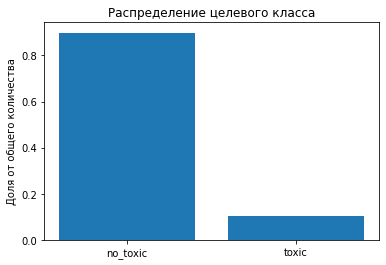

In [11]:
plt.title("Распределение целевого класса")
plt.ylabel("Доля от общего количества")
plt.bar(['no_toxic','toxic'], [1 - df['toxic'].sum() / len(df), df['toxic'].sum() / len(df)])

Имеет место дисбаланс целевого класса.

In [12]:
try:
    with open('features.pickle', 'rb') as f:
        embeddings = pickle.load(f)
except:
    tokenizer = BertTokenizer.from_pretrained('unitary/toxic-bert')
    model = AutoModel.from_pretrained('unitary/toxic-bert').to(device)
    tokenized = df['text'].apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=512, padding = 'max_length', truncation=True))
    tokenized = np.array([i for i in tokenized.values])
    display(tokenized.shape)
    attention_mask = np.where(tokenized != 0, 1, 0)
    batch_size = 100
    mod = tokenized.shape[0] % batch_size
    embeddings = []
    for i in notebook.tqdm(range(tokenized.shape[0] // batch_size)):
        batch = torch.LongTensor(tokenized[batch_size*i:batch_size*(i+1)]).cuda()
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)]).cuda()

        with torch.no_grad():
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)

        embeddings.append(batch_embeddings[0][:,0,:].cpu().numpy())

    batch = torch.LongTensor(tokenized[tokenized.shape[0] - mod:]).cuda()
    attention_mask_batch = torch.LongTensor(attention_mask[tokenized.shape[0] - mod:]).cuda()

    with torch.no_grad():
        batch_embeddings = model(batch, attention_mask=attention_mask_batch)

    embeddings.append(batch_embeddings[0][:,0,:].cpu().numpy())
    torch.cuda.empty_cache()

Some weights of the model checkpoint at unitary/toxic-bert were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


KeyboardInterrupt: 

In [ ]:
with open('features.pickle', 'wb') as f:
    pickle.dump(embeddings, f)

In [ ]:
features = np.concatenate(embeddings)
target = df['toxic']

In [ ]:
features_train, features_valid, target_train, target_valid = train_test_split(
    features,
    target,
    stratify=target,
    random_state = 42,
    test_size=0.4
)
features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid,
    target_valid,
    stratify=target_valid,
    random_state = 42,
    test_size=0.5
)

### Наивная модель (константное значение)

In [ ]:
model = DummyClassifier(strategy = 'constant', constant = 1)
model.fit(features_train, target_train)
preds = model.predict(features_test)
accuracy_score(target_test, preds)

### Логистическая регрессия

In [ ]:
model = LogisticRegression(random_state = 42)
model.fit(features_train, target_train)
preds = model.predict(features_valid)
f'F1_valid = {f1_score(target_valid, preds)}'

### Catboost classifier

In [ ]:
cv_dataset = Pool(data=features_train,
                  label=target_train)

model = CatBoostClassifier(iterations=1000,
                           depth=5,
                           learning_rate=0.01,
                           verbose=100,
                           eval_metric = "TotalF1"
                          )
model.fit(cv_dataset)

In [ ]:
preds = model.predict(features_valid)
f1_score(target_valid, preds)

### Случайный лес

In [ ]:
model = RandomForestClassifier(random_state = 42, class_weight='balanced')

grid_space={'max_depth':[3,5,10],
              'n_estimators':[50]
           }
grid = GridSearchCV(model,param_grid=grid_space,cv=4,scoring='f1', verbose=2, n_jobs=-1)
model_grid = grid.fit(np.concatenate([features_train, features_valid]), np.concatenate([target_train, target_valid]))
display(f'Best hyperparameters are: {model_grid.best_params_}')
display(f'Best estimator is: {model_grid.best_estimator_}')
display(f'Best score is: {model_grid.best_score_}')

### Полносвязная нейронная сеть

In [ ]:
model = MLPClassifier(hidden_layer_sizes=(64,64,64), learning_rate_init=0.001, max_iter=200, verbose=True, random_state = 42)
model.fit(features_train, target_train)
preds = model.predict(features_valid)
f1_score(target_valid, preds)

## Тестирование лучшей модели

### Логистическая регрессия

In [ ]:
model = LogisticRegression(random_state = 42)
model.fit(features_train, target_train)
preds = model.predict(features_test)
f1_score(target_test, preds)

## Выводы

В результате векторизации текстов с помощью BERT toxic получены эмбеддинги комментариев. Эмбеддинги использовались в качестве признаков при обучении логистической регрессии, случайного леса, модели catboost и полносвязной нейронной сети.

## Итоги

- Загружен и проанализирован датасет из текстов комментариев, проанализирован дисбаланс целевого класса
- Исходные тексты были переведены в пространство векторов токенизатором BERT и предобработанны моделью BERT, чтобы достичь лучшей связи между векторами
- Обучены модели: логистическая регрессия, случайный лес, catboost, полносвязная нейронная сеть. Их метрика F1 составила 0.945, 0.944, 0.94, 0.935 соответственно. Все из них прошли проверку на адекватность.
- По лучшему значению метрики F1 на валидационной выборке была выбрана модель - логистическая регрессия.
- Лучшая модель была протестирована на тестовой выборке с результатом F1 = 0.943, что удовлетворяет условию задачи.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Наивная-модель-(наиболее-часто-встречающееся-значение)" data-toc-modified-id="Наивная-модель-(наиболее-часто-встречающееся-значение)-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Наивная модель (наиболее часто встречающееся значение)</a></span></li><li><span><a href="#Логистическая-регрессия" data-toc-modified-id="Логистическая-регрессия-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Логистическая регрессия</a></span></li><li><span><a href="#Catboost-classifier" data-toc-modified-id="Catboost-classifier-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Catboost classifier</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Случайный лес</a></span></li><li><span><a href="#Полносвязная-нейронная-сеть" data-toc-modified-id="Полносвязная-нейронная-сеть-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Полносвязная нейронная сеть</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Итоги" data-toc-modified-id="Итоги-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Итоги</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>